## Here is panos code
We need to create 3 tests with brute force search(O(n))
1) with Linf metric
2) with Linf + Clustering
3) with Linf complete
4) with L2 metric

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

from utils import metrics as mt
from utils import geometry as geo
from utils import data as dt

In [4]:
# load data
data = np.load('./data_v2/1000sq/1000sq_1_12.npy')
q_points = np.load('./data_v2/1000sq/1000qp_1_12.npy')

In [5]:
print("Data shape: ", data.shape)
print("Querry points shape: ", q_points.__len__())

Data shape:  (1000, 4)
Querry points shape:  10000


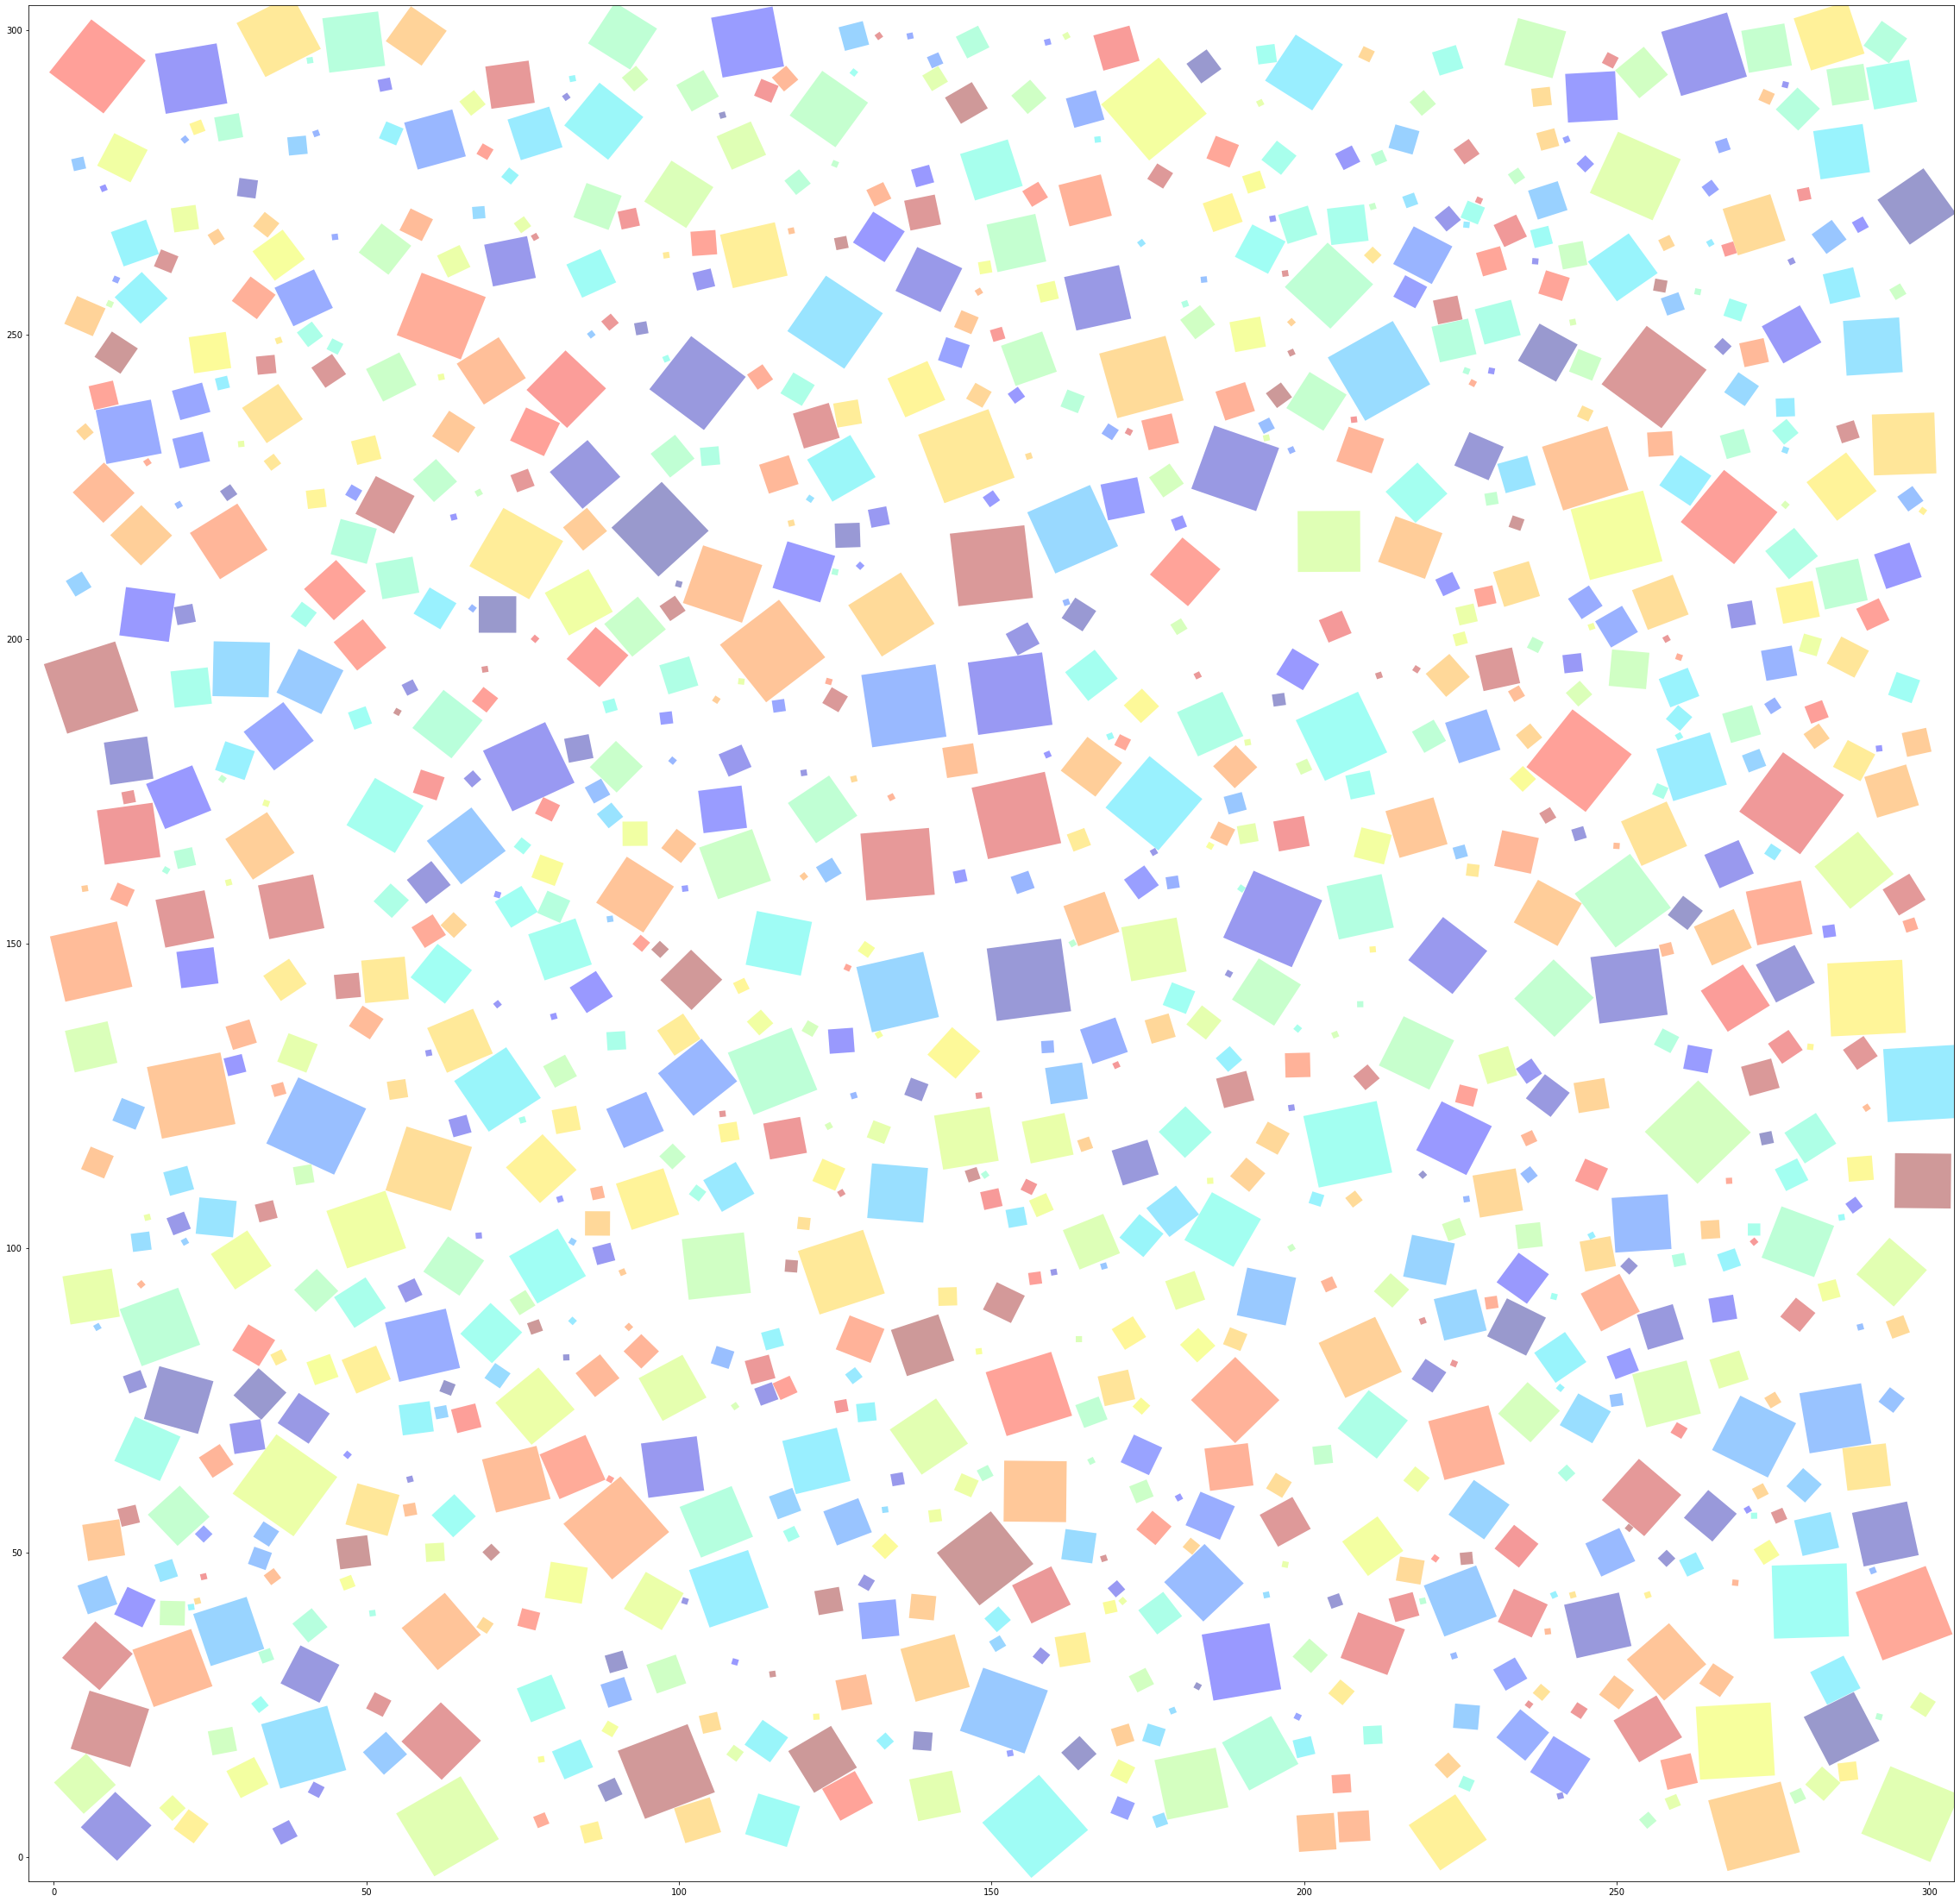

In [6]:
from utils import visualization as vis
min_ = 0
# 
#vis.plot_data(data, 20, [- max_ - max(size0), max_ + max(size0), -max_ - max(size0) , max_ + max(size0)])
vis.plot_data(data,40,[0-4,300+4,0-4,300+4])

In [7]:

from  sklearn.neighbors._kde import KernelDensity
from scipy.signal import argrelextrema
def GetBandwidth(data):
    # get bandwidth for kernel density estimation
    # bw must be limited by:
    # 1. it minimizes the distance between the maximum and mean of a cluster
    # 2. the distance between two cluster means is maximazied
    # or be chosen manually
    # or be chosen by cross validation
    # or so that the cluster's sizes are not too different from each other
    bandwidth = 0
    
  
    
    return bandwidth
def rclustering(dataset, bandwidth_method = 'opt'): 
    dataset = np.array(dataset)
    data = dataset[:,-1]
    if bandwidth_method == 'opt':
        bandwidth = GetBandwidth(data)
    else:
        bandwidth = float(bandwidth_method)
    #print("bandwidth: ", bandwidth)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data.reshape(-1, 1))
    s = np.linspace(0,90)
    e = kde.score_samples(s.reshape(-1,1))
    plt.plot(s, e)
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    # print them
    #print("minima: ", s[mi])
    #print("maxima: ", s[ma])
    # create a np.array of the clusters
    # maximum length is one more than minimum
    clusters = []
    for i in range(mi.__len__()):
        temp = []
        if i == 0:
            for j in range(data.__len__()):
                if data[j] <= s[mi[i]]:
                    temp.append(dataset[j])
            clusters.append(np.array(temp))
            continue
        if i > 0 and i <= mi.__len__()-1:
            for j in range(data.__len__()):
                if data[j] <= s[mi[i]] and data[j] > s[mi[i-1]]:
                    temp.append(dataset[j])
            clusters.append(np.array(temp))
            if i == mi.__len__()-1:
                temp = []
                for j in range(data.__len__()):
                    if data[j] > s[mi[i]]:
                        temp.append(dataset[j])
                clusters.append(np.array(temp))
            continue
    print("number of clusters: ", clusters.__len__())
    return np.array(clusters), s[mi], s[ma]
                
# compress data and calculate error for each cluster
def compress_data(clusters, min, max):
    print("No of clusters: ", clusters.__len__())
    print("No of min and max points: ", min.__len__(), max.__len__())
    error = [0 for i in range (clusters.__len__())]
    
    for i in range(clusters.__len__()):
        maxima = np.max(clusters[i][:,-1])
        print("maxima: ", maxima)
        mean = np.mean(clusters[i][:,-1])
        print("mean: ", mean)
        # calculate error
        for j in range(clusters[i].__len__()):
            error[i] += (maxima - clusters[i][j][-1])
            clusters[i][j][-1] = mean 
    return clusters , error

# create a cost function for w_error and bandwidth, so that u choose bandwidth to minimize w_error
# w_error must take into  account the number of clusters, we dont want to have too many clusters or too few
def cost_function(bandwidth):
    clusters, min, max = rclustering(data, bandwidth_method = bandwidth)
    new_data , error = compress_data(clusters, min, max)
    print("error: ", error)
    w_error = 0
    n_error = []
    for i in range(error.__len__()):
        w_error += np.abs(error[i])
        n_error.append( error[i] / clusters[i].__len__())
    return w_error,n_error, error, clusters.__len__()

number of clusters:  3
number of clusters:  3
No of clusters:  3
No of min and max points:  2 3
maxima:  47.75223747300913
mean:  22.053758681671006
maxima:  58.64078728345402
mean:  52.926909574570224
maxima:  89.91309439756508
mean:  69.73271921586912


C:\Users\wolfm\AppData\Local\Temp\ipykernel_20616\2454451676.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(clusters), s[mi], s[ma]
C:\Users\wolfm\AppData\Local\Temp\ipykernel_20616\2454451676.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(clusters), s[mi], s[ma]


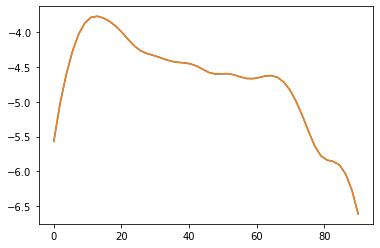

In [10]:
cluster,min_, max_ = rclustering(data, bandwidth_method = 3.3)
cluster1,min_, max_ = rclustering(data, bandwidth_method = 3.3)
cl_error = getClusterError(cluster)
clusters, error = compress_data(cluster, min_, max_)

In [9]:
def getClusterError(clusters):
    error = [0 for i in range (clusters.__len__())]
    for i in range(clusters.__len__()):
        error[i] = np.sin( np.deg2rad(np.max(clusters[i][:,-1]) - np.mean(clusters[i][:,-1])))    
    return error

In [11]:
for i in range(cluster1[0].__len__()):
    if np.abs(cluster1[0][i][-1] - cluster[0][i][-1])<= 0.1:
        print("same")
        print("i is ", i)
        print("cluster1: ", cluster1[0][i][-1])
        print("cluster: ", cluster[0][i][-1])
        break

same
i is  168
cluster1:  21.98429080398664
cluster:  22.053758681671006


In [12]:
def Linf_(square, q_point):
    """
        Compute the simplified Linf metric for a square and a point

        Parameters:
            square (np.array): square coordinates  
            q_point (np.array): point coordinates

        Returns:
            min_dist (float): minimum distance between the point and the square

    """
    min_dist = np.inf
    for point in square:
        dist = np.max(np.abs(np.subtract(point, q_point)))
        print(dist)
        if dist < min_dist:
            min_dist = dist
    return min_dist

In [225]:
ioi = 213
soi_ = data[ioi]
print(ioi)
soi_ = data[ioi]
# search for soi in cluster[0]
cl=-2
for i in range(cluster[cl].__len__()):
    if np.allclose(cluster[cl][i][0:-1], soi_[0:-1]):
        print("found")
        print("i is ", i)
        break
print("=====================================")
soi = cluster[cl][i]
print("soi:",soi)
print("soi_:",soi_)
a= mt.Linf_(geo.create_square2(soi), q_points[0])
print("Linf_:",a)
b=mt.Linf(geo.create_square2(soi_), q_points[0])[0]
print("Linf:",b)
print("q_points[0]: ", q_points[0])
print("a-b= ", a-b)

213
found
i is  43
soi: [ 27.         220.           4.          50.28788079]
soi_: [ 27.         220.           4.          57.82306635]
Linf_: 18.26066775753921
Linf: 17.163422844379664
q_points[0]:  [ 46 202]
a-b=  1.097244913159546


In [227]:
4*((1/np.sqrt(2)*(np.sin( np.deg2rad(soi_[-1]-soi[-1]))))+
   (np.sqrt(2)-1)/2*(np.sin( np.deg2rad(soi[-1]))))

1.0081853574010884

In [226]:
4*((1/np.sqrt(2)*(np.sin( np.deg2rad(soi_[-1]-soi[-1])))))+4*((np.sqrt(2)-1)/2*(np.sin( np.deg2rad(soi[-1]))))

1.0081853574010884

In [191]:
def Linf2(square, q_point, cluster, clusters):
    cl = cluster
    
    

17.163422844379664


In [118]:
a-b

0.13763190880152365

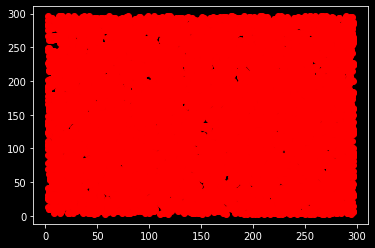

In [8]:
# visualize points in space
# plot 2d points of querry points
plt.plot(q_points[:,0],q_points[:,1], 'ro')

In [23]:
clusters[0]

array([[  6.        , 147.        ,  11.        ,  22.05375868],
       [115.        , 198.        ,  12.        ,  22.05375868],
       [286.        ,  21.        ,   9.        ,  22.05375868],
       ...,
       [167.        , 282.        ,   1.        ,  22.05375868],
       [ 64.        , 262.        ,   4.        ,  22.05375868],
       [225.        , 200.        ,   2.        ,  22.05375868]])

In [13]:
# get the first 10 points of the data
q_points = np.load('./data_v2/1000sq/1000qp_1_12.npy')
q_points = q_points[:1]
q_points.__len__()

1

j:  213
j:  213
ind:  [ 92 213 234 765 920]


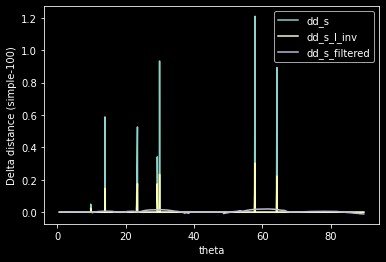

In [185]:
# init dd_s to be an array of zeros of size data.__len__()
dd_s = np.zeros(data.__len__())
dd_s_l_inv = np.zeros(data.__len__())

#dd_scl = []
dt = np.zeros(data.__len__())
t = np.zeros(data.__len__())

for j in range(data.__len__()):
    t[j] += data[j][-1]
for i in range(q_points.__len__()):

    for j in range(data.__len__()):
        l_inf_100 = mt.Linf(geo.create_square2(data[j]), q_points[i])[0]
        #print("l_inf_100: ", l_inf_100)
        
        l_inf_simple = mt.Linf_(geo.create_square2(data[j]), q_points[i])
        #print("l_inf_simple: ", l_inf_simple)
        if l_inf_simple-l_inf_100 > 1:
            print("j: ", j)
        dd_s[j] += (l_inf_simple-l_inf_100)
        if dd_s[j] > 1:
            print("j: ", j)
        dd_s_l_inv[j] += (l_inf_simple-l_inf_100)/data[j][-2]
# find ind of greater than 1 el in dd_s
ind = np.where(dd_s > .5)[0]
print("ind: ", ind)
# sort the dd_s and t
dd_s = dd_s[np.argsort(t)]
dd_s_l_inv = dd_s_l_inv[np.argsort(t)]
t = t[np.argsort(t)]
# norm

#dd_s = dd_s / np.max(dd_s)
#dd_s_l_inv = dd_s / np.max(dd_s)
# t = t / np.max(t)
# check if the dd_s is equal to the dd_s_l_inv

if np.array_equal(dd_s, dd_s_l_inv):
    print("dd_s and dd_s_l_inv are equal")
    
# sort the dd_s and t
#dd_s = dd_s[np.argsort(t)]
#t = t[np.argsort(t)]

# plot dd_s
plt.plot(t, dd_s)
plt.plot(t, dd_s_l_inv)
# put x label
plt.xlabel('theta')
# put y label
plt.ylabel('Delta distance (simple-100)')
# pass dd_s through a low pass filter
import scipy.signal as signal
dd_s_filtered = signal.savgol_filter(dd_s, 51*4+1, 3) # window size 51*4, polynomial order 3

# plot dd_s
plt.plot(t, dd_s_filtered)
# add legend
plt.legend(['dd_s', 'dd_s_l_inv', 'dd_s_filtered'])

In [187]:
data[213]

array([ 27.        , 220.        ,   4.        ,  57.82306635])

In [37]:
# find ind of greater than 1 el in dd_s
ind = np.where(dd_s > .5)[0]
print("ind: ", ind)

ind:  [231 377 481 798 857]


In [41]:
#q_points = np.load('./data_v2/1000sq/1000qpv2.npy')
q_points = np.load('./data_v1/1000sq/1000qp.npy')

nop = 10
beg = 0
q_points = q_points[beg:beg+nop]
print("q_points shape: ", q_points.shape)

q_points shape:  (10, 2)


i:  0


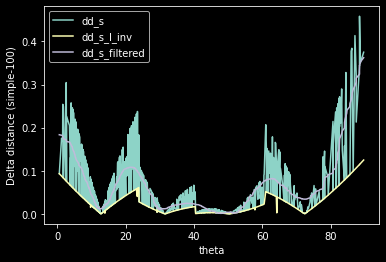

In [8]:
# init dd_s to be an array of zeros of size data.__len__()
dd_s = np.zeros(data.__len__())
dd_s_l_inv = np.zeros(data.__len__())

#dd_scl = []
dt = np.zeros(data.__len__())
t = np.zeros(data.__len__())

for j in range(data.__len__()):
    t[j] += data[j][-1]
for i in range(q_points.__len__()):
    print("i: ", i)

    for j in range(data.__len__()):
        l_inf_100 = mt.Linf(geo.create_square2(data[j]), q_points[i])[0]
        #print("l_inf_100: ", l_inf_100)
        # find index of data[j] in clusters
        index_k = -1
        index_l = -1
        for k in range(clusters.__len__()):
            for l in range(clusters[k].__len__()):
                if np.array_equal(data[j][0:-2], clusters[k][l][0:-2]):
                    index_k = k
                    index_l = l
                    #if data[j][-1] < 2:
                    #    print("data is: ", data[j])
                    #    print("cluster is: ", clusters[k][l])
                     #   print("j is: ", j)
                     #   print("k is: ", k)
                     #   print("l is: ", l)
                     #   break

                    
        
        l_inf_simple_clustered = mt.Linf(geo.create_square2(clusters[index_k][index_l]), q_points[i])[0]
        #print("l_inf_simple: ", l_inf_simple)
        dd_s[j] += abs(l_inf_simple_clustered-l_inf_100)
        dd_s_l_inv[j] += abs(l_inf_simple_clustered-l_inf_100)/data[j][-2]
        if dd_s_l_inv[j] > 0.9:
            print("==================================")
            print("l_inf_simple_clustered: ", l_inf_simple_clustered)
            print("l_inf_100: ", l_inf_100)
            print("dd_s_l_inv[j]: ", dd_s_l_inv[j])
            print("==================================")
            print("data is: ", data[j])
            print("cluster is: ", clusters[index_k][index_l])
            print(" index_k is: ", index_k)
            print(" index_l is: ", index_l)
            print("j is: ", j)
            break

            
# sort the dd_s and t
dd_s = dd_s[np.argsort(t)]
dd_s_l_inv = dd_s_l_inv[np.argsort(t)]
t = t[np.argsort(t)]
#norm
#dd_s = dd_s / np.max(dd_s)
#dd_s_l_inv = dd_s / np.max(dd_s)
# t = t / np.max(t)
# check if the dd_s is equal to the dd_s_l_inv

if np.array_equal(dd_s, dd_s_l_inv):
    print("dd_s and dd_s_l_inv are equal")
    
# sort the dd_s and t
#dd_s = dd_s[np.argsort(t)]
#t = t[np.argsort(t)]

# plot dd_s
plt.plot(t, dd_s)
plt.plot(t, dd_s_l_inv)
# put x label
plt.xlabel('theta')
# put y label
plt.ylabel('Delta distance (simple-100)')
# pass dd_s through a low pass filter
import scipy.signal as signal
dd_s_filtered = signal.savgol_filter(dd_s, 51*4+1, 3) # window size 51*4, polynomial order 3

# plot dd_s
plt.plot(t, dd_s_filtered)
# put legend
plt.legend(['dd_s', 'dd_s_l_inv', 'dd_s_filtered'])

i:  0


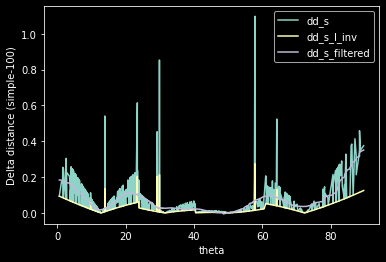

In [40]:

# init dd_s to be an array of zeros of size data.__len__()
dd_s = np.zeros(data.__len__())
dd_s_l_inv = np.zeros(data.__len__())

#dd_scl = []
dt = np.zeros(data.__len__())
t = np.zeros(data.__len__())

for j in range(data.__len__()):
    t[j] += data[j][-1]
for i in range(q_points.__len__()):
    print("i: ", i)

    for j in range(data.__len__()):
        l_inf_100 = mt.Linf(geo.create_square2(data[j]), q_points[i])[0]
        #print("l_inf_100: ", l_inf_100)
        # find index of data[j] in clusters
        index_k = -1
        index_l = -1
        for k in range(clusters.__len__()):
            for l in range(clusters[k].__len__()):
                if np.array_equal(data[j][0:-2], clusters[k][l][0:-2]):
                    index_k = k
                    index_l = l
                    #if data[j][-1] < 2:
                    #    print("data is: ", data[j])
                    #    print("cluster is: ", clusters[k][l])
                     #   print("j is: ", j)
                     #   print("k is: ", k)
                     #   print("l is: ", l)
                     #   break

                    
        
        l_inf_simple_clustered = mt.Linf_(geo.create_square2(clusters[index_k][index_l]), q_points[i])
        #print("l_inf_simple: ", l_inf_simple)
        dd_s[j] += abs(l_inf_simple_clustered-l_inf_100)
        dd_s_l_inv[j] += abs(l_inf_simple_clustered-l_inf_100)/data[j][-2]
        if dd_s_l_inv[j] > 0.9:
            print("==================================")
            print("l_inf_simple_clustered: ", l_inf_simple_clustered)
            print("l_inf_100: ", l_inf_100)
            print("dd_s_l_inv[j]: ", dd_s_l_inv[j])
            print("==================================")
            print("data is: ", data[j])
            print("cluster is: ", clusters[index_k][index_l])
            print(" index_k is: ", index_k)
            print(" index_l is: ", index_l)
            print("j is: ", j)
            break

            
# sort the dd_s and t
dd_s = dd_s[np.argsort(t)]
dd_s_l_inv = dd_s_l_inv[np.argsort(t)]
t = t[np.argsort(t)]
#norm
#dd_s = dd_s / np.max(dd_s)
#dd_s_l_inv = dd_s / np.max(dd_s)
# t = t / np.max(t)
# check if the dd_s is equal to the dd_s_l_inv

if np.array_equal(dd_s, dd_s_l_inv):
    print("dd_s and dd_s_l_inv are equal")
    
# sort the dd_s and t
#dd_s = dd_s[np.argsort(t)]
#t = t[np.argsort(t)]

# plot dd_s
plt.plot(t, dd_s)
plt.plot(t, dd_s_l_inv)
# put x label
plt.xlabel('theta')
# put y label
plt.ylabel('Delta distance (simple-100)')
# pass dd_s through a low pass filter
import scipy.signal as signal
dd_s_filtered = signal.savgol_filter(dd_s, 51*4+1, 3) # window size 51*4, polynomial order 3

# plot dd_s
plt.plot(t, dd_s_filtered)
# put legend
plt.legend(['dd_s', 'dd_s_l_inv', 'dd_s_filtered'])

In [126]:
# find ind of greater than 1 el in dd_s
ind = np.where(dd_s > .5)[0]
print("ind: ", ind)

ind:  [231 377 481 798 857]


In [ ]:
ind:  [231 377 481 798 857]

In [187]:
print(data[84])
print(clusters[3][15])
# get their dist
l1 = mt.Linf(geo.create_square2(data[84]), q_points[7])[0]
l2 = mt.Linf_(geo.create_square2(clusters[3][15]), q_points[7])
print("l1: ", l1)
print("l2: ", l2)

[ 60.         199.           3.          88.43496664]
[ 60.         199.           3.          72.35471158]
l1:  233.459592163708
l2:  233.1158881062418


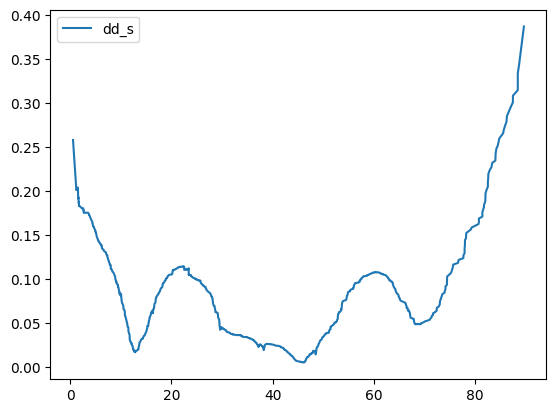

In [156]:
# get envelope of dd_s
from scipy.signal import hilbert, chirp
analytic_signal = hilbert(dd_s_filtered)
amplitude_envelope = np.abs(analytic_signal)
plt.plot(t, amplitude_envelope)
# put legend
plt.legend(['dd_s', 'dd_s_l_inv', 'dd_s_filtered', 'amplitude_envelope'])


In [141]:
cluster[1][0]

array([110.        , 212.        ,   3.        ,  31.54104331])

In [132]:
dd_s = dd_s[np.argsort(t)]
dd_s_l_inv = dd_s_l_inv[np.argsort(t)]
t = t[np.argsort(t)]

ValueError: window_length must be odd.

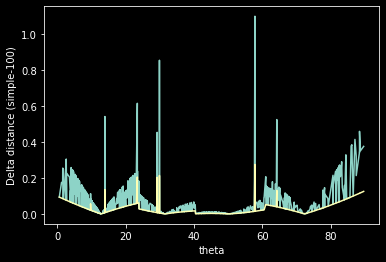

In [23]:
# sort the dd_s and t
dd_s = dd_s[np.argsort(t)]
dd_s_l_inv = dd_s_l_inv[np.argsort(t)]
t = t[np.argsort(t)]
#norm
#dd_s = dd_s / np.max(dd_s)
#dd_s_l_inv = dd_s / np.max(dd_s)
# t = t / np.max(t)
# check if the dd_s is equal to the dd_s_l_inv

if np.array_equal(dd_s, dd_s_l_inv):
    print("dd_s and dd_s_l_inv are equal")
    
# sort the dd_s and t
#dd_s = dd_s[np.argsort(t)]
#t = t[np.argsort(t)]

# plot dd_s
plt.plot(t, dd_s)
plt.plot(t, dd_s_l_inv)
# put x label
plt.xlabel('theta')
# put y label
plt.ylabel('Delta distance (simple-100)')
# pass dd_s through a low pass filter
import scipy.signal as signal
dd_s_filtered = signal.savgol_filter(dd_s, 51*4, 3) # window size 51*4, polynomial order 3

# plot dd_s
plt.plot(t, dd_s_filtered)

## Accuracy 

In [26]:
#q_points = np.load('./data_v2/1000sq/1000qpv2.npy')
q_points = np.load('./data_v2/1000sq/1000qp_1_12.npy')

nop = 10000
beg = 0
q_points = q_points[beg:beg+nop]
print("q_points shape: ", q_points.shape)

q_points shape:  (10000, 2)


In [27]:
acc1 = 0
acc = 0
dd_s = []
dd_scl = []
dt = []
for i in range(q_points.__len__()):
    #print("======================================")
    #print("New querry point:")
    
    # inside a point
    # bf with 100%

    min_dist_100 = np.inf
    min_id_100 = [-1]
    dista = []
    for j in range(data.__len__()):
        dist = mt.Linf(geo.create_square2(data[j]), q_points[i])[0] # get 100% Linf dist
        l_inf_100 = dist
        dista.append(dist)

        if dist < min_dist_100:
            min_dist_100 = dist
            min_id_100 = [-1]
            
            min_id_100[0] = j
            continue
        if dist  == min_dist_100:
            min_id_100.append(j)
    #print("min_id_100: ", min_id_100)
    # bf with simple Linf without clustering
    min_dist_simple = np.inf
    min_id_simple = [-1] 
    distb = []
    for j in range(data.__len__()):
        dist = mt.Linf_(geo.create_square2(data[j]), q_points[i])

        distb.append(dist)
        if dist < min_dist_simple:
            min_dist_simple = dist
            min_id_simple = [-1]
            min_id_simple[0] = j
            continue
        if dist == min_dist_simple:
            min_id_simple.append(j)
    #print("min_id_simple: ", min_id_simple)
    #print("min_id_100: ", min_id_100)
    if min_id_simple[0] == min_id_100[0]:
        acc1 += 1
    #print("min_id_simple: ", min_id_simple)

    
    # bf with simple Linf and clustering
    min_dist_m = [np.inf for _ in range(clusters.__len__())]
    min_id_m = [[-1] for _ in range(clusters.__len__())]
    for c in range(clusters.__len__()):
        for j in range(clusters[c].__len__()):
            dist = mt.Linf_(geo.create_square2(clusters[c][j]),q_points[i])
            if dist < min_dist_m[c]:
                min_dist_m[c] = dist 
                min_id_m[c] = [-1]
                min_id_m[c][0] = j
                continue
            if dist == min_dist_m[c]:
                # insert to cluster in last position
                min_id_m[c].append(j)
                #min_id_m[c].insert() # TODO
    
    #print("min_id_m: ", min_id_m)

    for c in range(clusters.__len__()):
        for i in range(min_id_m[c].__len__()):
            #print("Squares are : ", clusters[c][min_id_m[c][i]][0:2], data[min_id_100[0]][0:2])
            if np.all(clusters[c][min_id_m[c][i]][0:2] == data[min_id_100[0]][0:2]):
                #print("Squares are : ", clusters[c][min_id_m[c][i]][0:2], data[min_id_100[0]][0:2])
                acc += 1
                break
    #min_dist_t = np.inf
    #min_id_t = [-1]
    #for id in min_id_m:
    #    dist = mt.Linf(geo.create_square2(data[id]), q_points[i])[0]
    #    if dist < min_dist_t:
    #        min_dist_t = dist
    #        min_id_t = [-1]
    #        min_id_t[0] = id
    #    if dist == min_dist_t:
    #        min_id_t.append(id)

####

print("Acc and clustering is: {} %".format(acc/nop*100))
print("Acc Simple is: {} %".format(acc1/nop*100))

# print accuracy is acc %
#print('Accuracy is: {}%'.format(acc/nop*100))

Acc and clustering is: 88.86 %
Acc Simple is: 83.00999999999999 %


In [29]:

# load data
data = np.load('./data_v1/1000sq/5000sq.npy')
#q_points = np.load('./data_v1/1000sq/1000qp.npy')#q_points = np.load('./data_v2/1000sq/1000qpv2.npy')
q_points = np.load('./data_v1/1000sq/1000qp.npy')

nop = 1
beg = 0
q_points = q_points[beg:beg+nop]
print("q_points shape: ", q_points.shape)

q_points shape:  (1, 2)


In [30]:
%%timeit
acc1 = 0
acc = 0
dd_s = []
dd_scl = []
dt = []
for i in range(q_points.__len__()):
    #print("======================================")
    #print("New querry point:")
    
    # inside a point
    # bf with 100%

    min_dist_100 = np.inf
    min_id_100 = [-1]
    dista = []
    for j in range(data.__len__()):
        dist = mt.Linf(geo.create_square2(data[j]), q_points[i])[0] # get 100% Linf dist
        l_inf_100 = dist
        dista.append(dist)

        if dist < min_dist_100:
            min_dist_100 = dist
            min_id_100 = [-1]
            
            min_id_100[0] = j
            continue
        if dist  == min_dist_100:
            min_id_100.append(j)
 

324 ms ± 8.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
70*10000/1000/60

11.666666666666666

In [26]:
(634-322)/634*100

49.21135646687697

In [ ]:
634=10*1000*0.0634